In [17]:
from barpa_read import drop_duplicates, file_dates
import xarray as xr
import metpy.calc as mpcalc
import metpy.units as units
import datetime as dt
import numpy as np
from barra_read import date_seq
import glob
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [7]:
#Load HUS, T for BARPA
experiment="era"
forcing_mdl="erai"
ensemble="r0"
time = [dt.datetime(1990,1,1,0), dt.datetime(1990,1,31,18)]

query_dates = date_seq(time, "hours", 6)
barpa_hus_files = np.sort(glob.glob("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/"+\
                    experiment+"/"+forcing_mdl+\
                    "/"+ensemble+"/*/*/pp2/spec_hum*"))
barpa_ta_files = np.sort(glob.glob("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/"+\
                    experiment+"/"+forcing_mdl+\
                    "/"+ensemble+"/*/*/pp2/air_temp*"))
barpa_hus_files = barpa_hus_files[file_dates(barpa_hus_files, query_dates)]
barpa_ta_files = barpa_ta_files[file_dates(barpa_ta_files, query_dates)]
hus_barpa = drop_duplicates(xr.open_mfdataset(barpa_hus_files, concat_dim="time", combine="nested"))     #1 (kg/kg?)
ta_barpa = drop_duplicates(xr.open_mfdataset(barpa_ta_files, concat_dim="time", combine="nested"))       #K
hus_barpa = hus_barpa.interp({"latitude":-12.462827, "longitude":130.841782}).persist()
ta_barpa = ta_barpa.interp({"latitude":-12.462827, "longitude":130.841782}).persist()

        

[########################################] | 100% Completed | 32.6s
[########################################] | 100% Completed | 32.6s
[########################################] | 100% Completed | 23.5s
[########################################] | 100% Completed | 23.6s


In [9]:
#Load HUS, T for BARRA
query_dates = date_seq(time, "hours", 6)
barra_hur_files = np.sort(glob.glob("/g/data/ma05/prod/BARRA_R/v1/forecast/prs/relhum/"+\
                    "/1990/01/relhum*"))
barra_ta_files = np.sort(glob.glob("/g/data/ma05/prod/BARRA_R/v1/forecast/prs/air_temp/"+\
                    "/1990/01/air_temp*"))
hur_barra = drop_duplicates(xr.open_mfdataset(barra_hur_files, concat_dim="time", combine="nested"))     #1 (kg/kg?)
ta_barra = drop_duplicates(xr.open_mfdataset(barra_ta_files, concat_dim="time", combine="nested"))       #K
hur_barra = hur_barra.sel({"time":np.in1d(hur_barra.time,hur_barra.time)}).interp({"latitude":-12.462827, "longitude":130.841782}).persist()
ta_barra = ta_barra.sel({"time":np.in1d(ta_barra.time,ta_barra.time)}).interp({"latitude":-12.462827, "longitude":130.841782}).persist()

#Even up times
hus_barpa = hus_barpa.sel({"time":np.in1d(hus_barpa.time, hur_barra.time)})
ta_barpa = ta_barpa.sel({"time":np.in1d(ta_barpa.time, ta_barra.time)})
    

[########################################] | 100% Completed | 17min 43.0s
[########################################] | 100% Completed | 17min 43.1s
[########################################] | 100% Completed | 16min 47.1s
[########################################] | 100% Completed | 16min 47.2s


In [64]:
hus_barpa_arvo = hus_barpa.sel({"time":np.in1d(hus_barpa["time.hour"], [6])})
hur_barra_arvo = hur_barra.sel({"time":np.in1d(hur_barra["time.hour"], [6])})
ta_barpa_arvo = ta_barpa.sel({"time":np.in1d(ta_barpa["time.hour"], [6])})
ta_barra_arvo = ta_barra.sel({"time":np.in1d(ta_barra["time.hour"], [6])})

hus_barpa_arvo = xr.where(ta_barpa_arvo.air_temp_uv.values < 1., np.nan, hus_barpa_arvo.spec_hum_uv)
ta_barpa_arvo = xr.where(ta_barpa_arvo.air_temp_uv.values < 1., np.nan, ta_barpa_arvo.air_temp_uv)

barra_dp = mpcalc.dewpoint_rh(ta_barra_arvo.air_temp, hur_barra_arvo.relhum/100)
barpa_dp = mpcalc.dewpoint_from_specific_humidity(hus_barpa_arvo, ta_barpa_arvo.values*units.units.kelvin, ta_barpa_arvo.pressure )

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/pint/quantity.py:1488: RuntimeWarning: divide by zero encountered in log
  return ufunc(*mobjs)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/pint/quantity.py:888: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/pint/quantity.py:1175: RuntimeWarning: invalid value encountered in greater
  return op(self._convert_magnitude_not_inplace(UnitsContainer()), other)


In [67]:
barra_mean_dp = np.nanmean(barra_dp, axis=0)
barpa_mean_dp = np.nanmean(barpa_dp, axis=0)
barra_mean_ta = np.nanmean(ta_barra_arvo.air_temp, axis=0)
barpa_mean_ta = np.nanmean(ta_barpa_arvo, axis=0)

[########################################] | 100% Completed |  0.1s


/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


(1000, 100)

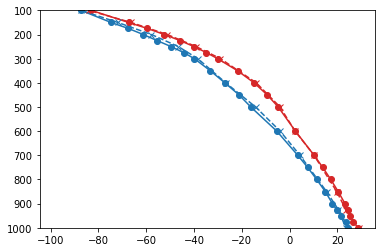

In [75]:
ax=plt.gca()
ax.plot(barra_mean_dp, ta_barra.pressure, marker="o")
ax.plot(barra_mean_ta-273.15, ta_barra.pressure, color="tab:red", marker="o")
ax.plot(barpa_mean_dp, ta_barpa.pressure, linestyle="--", marker="x", color="tab:blue")
ax.plot(barpa_mean_ta-273.15, ta_barpa.pressure, color="tab:red", linestyle="--", marker="x")

ax.invert_yaxis()
plt.ylim([1000, 100])

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

(200, 305)

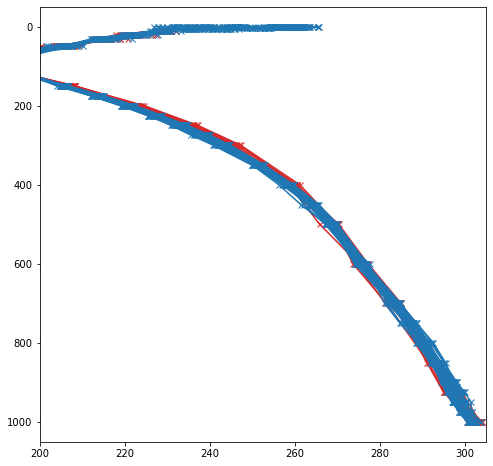

In [72]:
plt.figure(figsize=[8,8])
[plt.plot(ta_barpa_arvo.isel({"time":i}), ta_barpa_arvo.pressure, marker="x", color="tab:red") for i in np.arange(31)]
[plt.plot(ta_barra_arvo.air_temp.isel({"time":i}), ta_barra_arvo.pressure, marker="x", color="tab:blue") for i in np.arange(31)]
ax=plt.gca()
ax.invert_yaxis()
plt.xlim([200,305])

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


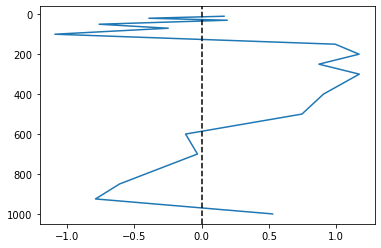

In [87]:
plt.plot((ta_barpa_arvo - ta_barra_arvo.air_temp).mean("time"), ta_barpa_arvo.pressure)
ax=plt.gca()
ax.invert_yaxis()
plt.axvline(0, color="k", linestyle="--")